<a href="https://colab.research.google.com/github/CharFox1/CompVisProj/blob/main/lstmCharModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, tensor
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision.transforms as T
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

In [3]:
!unzip handwrittenChars.zip

Archive:  handwrittenChars.zip
   creating: handwrittenChars/
   creating: handwrittenChars/.ipynb_checkpoints/
  inflating: handwrittenChars/.ipynb_checkpoints/parseHandwrittenChars-checkpoint.ipynb  
  inflating: handwrittenChars/parseHandwrittenChars.ipynb  
  inflating: handwrittenChars/trainSmall.npy  
  inflating: handwrittenChars/valSmall.npy  


In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [ ]:
# Manually pick cpu device if desired
device = "cpu"

In [5]:
# resnet block to be used in models below
# code modified from "resnet-34-pytorch-starter-kit"

class resBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1, kernel_size=3, padding=1, bias=False):
    super(resBlock, self).__init__()
    
    self.cnn1 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(True)
    )

    self.cnn2 = nn.Sequential(
        nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding, bias=False),
        nn.BatchNorm2d(out_channels)
    )

    # if the output image will be a different size than the input
    # must reshape residual to fit new output shape
    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(out_channels)
      )
    # otherwise just pass it through 
    else:
      self.shortcut = nn.Sequential()

  def forward(self, x):
    residual = x
    x = self.cnn1(x)
    x = self.cnn2(x)
    x += self.shortcut(residual)
    x = nn.ReLU(True)(x)
    return x

In [6]:
# small function to turn int index into one hot encoding
def oneHot(num, numClasses):
  output = [0] * numClasses
  output[num] = 1
  return output

training data size: 78000
validation data size: 13000
training data shape: (32, 32)


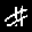

data type of image = <class 'numpy.ndarray'>
training data label: #
each index in dataset has image (32x32) and char label
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [7]:
# get conv demo data (https://www.kaggle.com/vaibhao/handwritten-characters)
from google.colab.patches import cv2_imshow #allows us to show images

# grab small files (created from larger dataset)
# this is the location they should be in the github
# if you are running in collab, you need to import the handwrittenChars folder as a zip
# you can unzip it with "!unzip handwrittenChars.zip" in a separate cell
with open("handwrittenChars/trainSmall.npy", "rb") as f:
    conv_train_data = np.load(f, allow_pickle=True)

with open("handwrittenChars/valSmall.npy", "rb") as f:
    conv_val_data = np.load(f, allow_pickle=True)

conv_val_data = conv_val_data[:13000]

print("training data size:", len(conv_train_data))
print("validation data size:", len(conv_val_data))

print("training data shape:", conv_train_data[1201][0].shape)
cv2_imshow(conv_train_data[1201][0])
print("data type of image =", type(conv_train_data[1201][0]))
print("training data label:", conv_train_data[1201][1])
print("each index in dataset has image (32x32) and char label")
print(conv_train_data[1201][0])

In [8]:
labels = []
# used for stopping prediction of recurrent layers
labels.append("<EOS>") 
for i in conv_train_data:
  label = i[1]
  if label not in labels:
    labels.append(label)

print("there are", len(labels), "labels in the training dataset")

for i in conv_val_data:
  label = i[1]
  if label not in labels:
    labels.append(label)

print("there are", len(labels), "labels in the validation dataset")

labelDict = {}
for i in range(len(labels)):
  labelDict[i] = labels[i]

print(labelDict)
invertedLabelDict = {y:x for x,y in labelDict.items()}
print(invertedLabelDict)

there are 40 labels in the training dataset
there are 40 labels in the validation dataset
{0: '<EOS>', 1: '#', 2: '$', 3: '&', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: '@', 15: 'A', 16: 'B', 17: 'C', 18: 'D', 19: 'E', 20: 'F', 21: 'G', 22: 'H', 23: 'I', 24: 'J', 25: 'K', 26: 'L', 27: 'M', 28: 'N', 29: 'P', 30: 'Q', 31: 'R', 32: 'S', 33: 'T', 34: 'U', 35: 'V', 36: 'W', 37: 'X', 38: 'Y', 39: 'Z'}
{'<EOS>': 0, '#': 1, '$': 2, '&': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, '@': 14, 'A': 15, 'B': 16, 'C': 17, 'D': 18, 'E': 19, 'F': 20, 'G': 21, 'H': 22, 'I': 23, 'J': 24, 'K': 25, 'L': 26, 'M': 27, 'N': 28, 'P': 29, 'Q': 30, 'R': 31, 'S': 32, 'T': 33, 'U': 34, 'V': 35, 'W': 36, 'X': 37, 'Y': 38, 'Z': 39}


In [9]:
# dataset class
class handwrittenCharsDataset(Dataset):
    def __init__(self, X, classToNum):
      self.classToNum = classToNum
      self.images = []
      self.labels = []
      for i in X:
        self.images.append(i[0])
        self.labels.append(i[1])

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, index):
      image = self.images[index]
      # since lstm is being used but there is always only 1 char, no need to worry about parsing label
      # just make one hot vector for char and end token and put them together in tensor
      char = self.classToNum[self.labels[index]]
      end = self.classToNum["<EOS>"]
      label = tensor([char, end])
      image = self.transform(image)
      sample = [image, label]
      return sample

    transform = T.Compose([
      T.ToPILImage(),
      T.ToTensor()                     
    ])

In [10]:
batch_size = 10
dataset = handwrittenCharsDataset(X=conv_train_data, classToNum=invertedLabelDict)
train_dl = DataLoader(dataset, batch_size, shuffle=True, pin_memory=True)

In [11]:
def toChars(nums, dict):
  out = []
  for num in nums:
    out.append(dict[num])
  return out

In [12]:
# recurrent conv model to look at image and predict chars until all are read
# uses resnet structure

class convLSTM(nn.Module):
  def __init__(self, numClasses, batchSize, maxLen):
    super(convLSTM, self).__init__()
    self.numClasses = numClasses
    self.batchSize = batchSize
    self.maxLen = maxLen

    self.block1 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=2, stride=2, padding=3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True)
    )

    self.block2 = nn.Sequential(
        nn.MaxPool2d(1, 1),
        resBlock(64, 64),
        resBlock(64, 64, 2)
    )

    self.block3 = nn.Sequential(
        resBlock(64, 128),
        resBlock(128, 128, 2)
    )

    self.block4 = nn.Sequential(
        resBlock(128, 256),
        resBlock(256, 256, 2)
    )

    self.block5 = nn.Sequential(
        resBlock(256, 512),
        resBlock(512, 512, 2)
    )

    self.avgpool = nn.AvgPool2d(2)
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(512, 512)
    self.l2 = nn.Linear(512, 256)
    self.l3 = nn.Linear(256, numClasses)
    # input size, hidden size, num layers
    self.lstm = nn.LSTM(256, 256)
    # turn values to 0 with probability 0.2
    self.drop1 = nn.Dropout(0.2)
    self.drop2 = nn.Dropout(0.2)

  def forward(self, x, hidden):
    # resnet layers
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.avgpool(x)
    x = self.flatten(x)
    
    # reduce size of data and add dropout for better generalization
    x = self.l1(x)
    x = self.drop1(x)
    x = self.l2(x)
    x = self.drop2(x)
    
    # reshape image encoding so it has time dim on front
    x = x.reshape(1, self.batchSize, 256)

    #h0 = torch.zeros(1, self.batchSize, 256).to(device)
    #c0 = torch.zeros(1, self.batchSize, 256).to(device)

    x, hidden = self.lstm(x, hidden)

    # turn output to classes
    x = self.l3(x)
    return x, hidden

  def init_hidden(self):
    return (torch.zeros(1, self.batchSize, 256).to(device),
            torch.zeros(1, self.batchSize, 256).to(device))

In [13]:
def parsePred(pred):
  pred = pred.detach().cpu().numpy()
  #print(pred)
  out = []
  for i in pred:
    #print(i[0])
    out.append(labelDict[i.argmax(0).item()])

  return "".join(out)

In [14]:
# init model with 40 classes on output layer
# batch size = 10
# 2 is max chars in sequence
# put model in gpu if available
LSTMModel = convLSTM(40, 10, 2).to(device)
#print(LSTMModel)

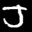

predicted K4 for J<EOS>


In [15]:
testItem, testLabel = next(iter(train_dl))
#print(f"Feature batch shape: {testItem.size()}")
#print(f"Labels batch shape: {testLabel.size()}")

#testLabel = labelDict[testLabel[0].numpy().argmax()]
testLabel = testLabel.numpy()[0]

# some funny business to get image from tensor to see if guess is reasonable
image = testItem[0].cpu().numpy()[0] * 255
cv2_imshow(image)

hidden = LSTMModel.init_hidden()

# predict twice with same image but different hidden
output, hidden = LSTMModel(testItem.to(device), hidden)
output2, hidden = LSTMModel(testItem.to(device), hidden)

pred1 = labelDict[output[0][0].detach().cpu().numpy().argmax(0)]
pred2 = labelDict[output2[0][0].detach().cpu().numpy().argmax(0)]

print("predicted", pred1 + pred2, "for", "".join(toChars(testLabel, labelDict)))

In [16]:
# function to find accuracy for variable size output
def findAccuracy(pred, labels):

  accuracy = 0

  #print(pred.shape)
  #print(labels.shape)

  for p, l in zip(pred, labels):
    for b in range(len(p)):
      #print(p[b])
      if p[b].argmax(0).item() == l[b]:
        accuracy += 1

  return accuracy/(pred.shape[0] * pred.shape[1])

In [17]:
# NOT USED

# function to define loss for variable size output
# works like categorical crossentropy for each of the char predictions
def lstmLoss(pred, labels, lossFunc):
  pred = pred.permute(1,0,2)
  #print(pred.shape)
  labels = labels.permute(1,0)
  #print(labels.shape)
  loss = []
  for char, lab in zip(pred, labels):
    #print(char.shape)
    #print(lab.shape)
    loss.append(lossFunc(char, lab))
  return loss

In [18]:
#LSTMModel = convLSTM(40, 10, 2).to(device)

lossFunc = nn.CrossEntropyLoss()
opt = optim.SGD(LSTMModel.parameters(), lr=0.001) 

num_epochs = 5
max_len = 2
batch_size = 10

testLoss = []
testAcc = []

for epoch in range(num_epochs):
  running_loss = 0
  running_acc = 0
  for i, data in enumerate(train_dl, 0):
    images, labels = data
    images, labels = images.to(device), labels.permute(1,0).to(device)

    opt.zero_grad()

    hidden = LSTMModel.init_hidden()

    outputs = []
    losses = []
    for j in range(max_len):
      LSTMModel.zero_grad()
      #hidden[0].detach_()
      #hidden[1].detach_()

      #print(images.shape)
      #print(hidden[0].shape)

      output, hidden = LSTMModel(images, hidden)
      hidden = (hidden[0].detach(), hidden[1].detach())

      #print(output[0].shape)
      #print(labels[j])

      loss = lossFunc(output[0], labels[j])
      #print(loss)
      loss.backward()
      opt.step()

      outputs.append(output[0])
      losses.append(loss)

    outputs = torch.stack(outputs)
    running_acc += findAccuracy(outputs, labels)

    #print(loss)
    running_loss += sum(losses).item()
    if i % 1000 == 999:
      testLoss.append(running_loss)
      testAcc.append(running_acc/10)
      print("[%d, %5d] loss: %.5f acc: %.3f%%" % (epoch + 1, i + 1, running_loss / 1000, running_acc / 10))
      running_loss = 0
      running_acc = 0

print("Done!")

[1,  1000] loss: 5.47372 acc: 46.995%
[1,  2000] loss: 4.44516 acc: 50.000%
[1,  3000] loss: 4.34066 acc: 50.000%
[1,  4000] loss: 4.23728 acc: 50.000%
[1,  5000] loss: 4.13846 acc: 50.000%
[1,  6000] loss: 4.01338 acc: 50.000%
[1,  7000] loss: 3.84248 acc: 50.000%
[2,  1000] loss: 3.41915 acc: 50.730%
[2,  2000] loss: 3.12957 acc: 53.620%
[2,  3000] loss: 2.80466 acc: 60.880%
[2,  4000] loss: 2.49115 acc: 69.905%
[2,  5000] loss: 2.17497 acc: 77.610%
[2,  6000] loss: 1.89323 acc: 82.875%
[2,  7000] loss: 1.63725 acc: 86.190%
[3,  1000] loss: 1.25183 acc: 90.285%
[3,  2000] loss: 1.08444 acc: 91.350%
[3,  3000] loss: 0.93721 acc: 92.295%
[3,  4000] loss: 0.82078 acc: 93.090%
[3,  5000] loss: 0.72077 acc: 93.825%
[3,  6000] loss: 0.65132 acc: 94.010%
[3,  7000] loss: 0.58481 acc: 94.300%
[4,  1000] loss: 0.48572 acc: 95.230%
[4,  2000] loss: 0.44957 acc: 95.530%
[4,  3000] loss: 0.41514 acc: 95.720%
[4,  4000] loss: 0.39848 acc: 95.655%
[4,  5000] loss: 0.39431 acc: 95.390%
[4,  6000] l

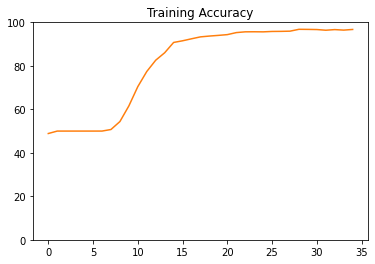

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(testAcc, color="tab:orange")
ax.set_ylim([0,100])
ax.set_title("Training Accuracy")
plt.show()

In [ ]:
batch_size = 10
dataset = handwrittenCharsDataset(X=conv_val_data, classToNum=invertedLabelDict)
train_dl = DataLoader(dataset, batch_size, shuffle=True, pin_memory=True)

In [ ]:
num_epochs = 3
max_len = 2
batch_size = 10

valLoss = []
valAcc = []

for epoch in range(num_epochs):
  running_loss = 0
  running_acc = 0
  for i, data in enumerate(train_dl, 0):
    images, labels = data
    images, labels = images.to(device), labels.permute(1,0).to(device)

    opt.zero_grad()

    hidden = LSTMModel.init_hidden()

    outputs = []
    losses = []
    for j in range(max_len):
      LSTMModel.zero_grad()
      #hidden[0].detach_()
      #hidden[1].detach_()

      #print(images.shape)
      #print(hidden[0].shape)

      output, hidden = LSTMModel(images, hidden)
      hidden = (hidden[0].detach(), hidden[1].detach())

      #print(output[0].shape)
      #print(labels[j])

      loss = lossFunc(output[0], labels[j])
      #print(loss)
      #loss.backward()
      #opt.step()

      outputs.append(output[0])
      losses.append(loss)

    outputs = torch.stack(outputs)
    running_acc += findAccuracy(outputs, labels)

    #print(loss)
    running_loss += sum(losses).item()
    if i % 1000 == 999:
      valLoss.append(running_loss)
      valAcc.append(running_acc/10)
      print("[%d, %5d] loss: %.5f acc: %.3f%%" % (epoch + 1, i + 1, running_loss / 1000, running_acc / 10))
      running_loss = 0
      running_acc = 0

print("Done!")

[1,  1000] loss: 1.14879 acc: 88.275%
[2,  1000] loss: 1.15740 acc: 88.100%
[3,  1000] loss: 1.14069 acc: 88.100%
Done!


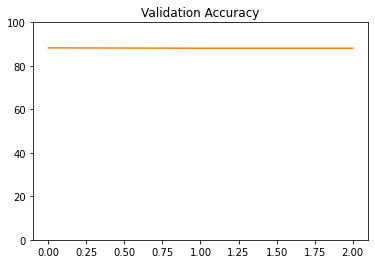

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(valAcc, color="tab:orange")
ax.set_ylim([0,100])
ax.set_title("Validation Accuracy")
plt.show()

In [ ]:
# dataset class with corner detection added (may make things more difficult)
class handwrittenCharsCornerDataset(Dataset):
    def __init__(self, X, classToNum):
      self.classToNum = classToNum
      self.images = []
      self.labels = []
      for i in X:
        self.images.append(i[0])
        self.labels.append(i[1])

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, index):
      # apply corner detection to image
      image = np.float32(self.images[index])
      image = image * cv2.cornerHarris(image, 2, 3, 0.04)

      char = self.classToNum[self.labels[index]]
      end = self.classToNum["<EOS>"]
      label = tensor([char, end])

      image = self.transform(image)
      sample = [image, label]
      return sample
    
    transform = T.Compose([
      T.ToPILImage(),
      T.ToTensor()                     
    ])

In [ ]:
batch_size = 10
dataset = handwrittenCharsCornerDataset(X=conv_train_data, classToNum=invertedLabelDict)
cornerTrain_dl = DataLoader(dataset, batch_size, shuffle=True, pin_memory=True)

In [ ]:
# init model with 40 classes on output layer
# batch size = 10
# 2 is max chars in sequence
# put model in gpu if available
CornerLSTMModel = convLSTM(40, 10, 2).to(device)
#print(LSTMModel)

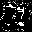

predicted U<EOS> for U<EOS>


In [ ]:
testItem, testLabel = next(iter(cornerTrain_dl))
#print(f"Feature batch shape: {testItem.size()}")
#print(f"Labels batch shape: {testLabel.size()}")

#testLabel = labelDict[testLabel[0].numpy().argmax()]
testLabel = testLabel.numpy()[0]

# some funny business to get image from tensor to see if guess is reasonable
image = testItem[0].cpu().numpy()[0] * 255
cv2_imshow(image)

hidden = CornerLSTMModel.init_hidden()

# predict twice with same image but different hidden
output, hidden = CornerLSTMModel(testItem.to(device), hidden)
output2, hidden = CornerLSTMModel(testItem.to(device), hidden)

pred1 = labelDict[output[0][0].detach().cpu().numpy().argmax(0)]
pred2 = labelDict[output2[0][0].detach().cpu().numpy().argmax(0)]

print("predicted", pred1 + pred2, "for", "".join(toChars(testLabel, labelDict)))

In [ ]:
lossFunc = nn.CrossEntropyLoss()
opt = optim.SGD(CornerLSTMModel.parameters(), lr=0.001) 

num_epochs = 5
max_len = 2
batch_size = 10

LSTMtestLoss = []
LSTMtestAcc = []

for epoch in range(num_epochs):
  running_loss = 0
  running_acc = 0
  for i, data in enumerate(cornerTrain_dl, 0):
    images, labels = data
    images, labels = images.to(device), labels.permute(1,0).to(device)

    opt.zero_grad()

    hidden = CornerLSTMModel.init_hidden()

    outputs = []
    losses = []
    for j in range(max_len):
      CornerLSTMModel.zero_grad()
      #hidden[0].detach_()
      #hidden[1].detach_()

      #print(images.shape)
      #print(hidden[0].shape)

      output, hidden = CornerLSTMModel(images, hidden)
      hidden = (hidden[0].detach(), hidden[1].detach())

      #print(output[0].shape)
      #print(labels[j])

      loss = lossFunc(output[0], labels[j])
      #print(loss)
      loss.backward()
      opt.step()

      outputs.append(output[0])
      losses.append(loss)

    outputs = torch.stack(outputs)
    running_acc += findAccuracy(outputs, labels)

    #print(loss)
    running_loss += sum(losses).item()
    if i % 1000 == 999:
      LSTMtestLoss.append(running_loss)
      LSTMtestAcc.append(running_acc/10)
      print("[%d, %5d] loss: %.5f acc: %.3f%%" % (epoch + 1, i + 1, running_loss / 1000, running_acc / 10))
      running_loss = 0
      running_acc = 0

print("Done!")

[1,  1000] loss: 5.56157 acc: 48.400%
[1,  2000] loss: 4.47824 acc: 50.000%
[1,  3000] loss: 4.39765 acc: 50.000%
[1,  4000] loss: 4.30606 acc: 50.000%
[1,  5000] loss: 4.19796 acc: 50.000%
[1,  6000] loss: 4.07397 acc: 50.000%
[1,  7000] loss: 3.94622 acc: 50.030%
[2,  1000] loss: 3.68766 acc: 50.540%
[2,  2000] loss: 3.55134 acc: 51.310%
[2,  3000] loss: 3.40052 acc: 53.245%
[2,  4000] loss: 3.23160 acc: 56.195%
[2,  5000] loss: 3.06545 acc: 59.390%
[2,  6000] loss: 2.87635 acc: 62.235%
[2,  7000] loss: 2.66348 acc: 65.705%
[3,  1000] loss: 2.30184 acc: 71.535%
[3,  2000] loss: 2.09118 acc: 74.880%
[3,  3000] loss: 1.90122 acc: 78.030%
[3,  4000] loss: 1.70102 acc: 80.930%
[3,  5000] loss: 1.53972 acc: 83.295%
[3,  6000] loss: 1.37654 acc: 85.670%
[3,  7000] loss: 1.23783 acc: 87.500%
[4,  1000] loss: 1.00445 acc: 90.135%
[4,  2000] loss: 0.89318 acc: 91.390%
[4,  3000] loss: 0.82866 acc: 91.710%
[4,  4000] loss: 0.74795 acc: 92.360%
[4,  5000] loss: 0.68584 acc: 92.930%
[4,  6000] l

35
35


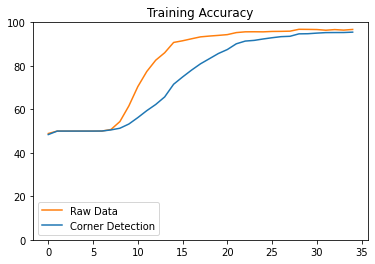

In [ ]:
print(len(testAcc))
print(len(LSTMtestAcc))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(testAcc, color="tab:orange", label="Raw Data")
ax.plot(LSTMtestAcc, color="tab:blue", label="Corner Detection")
ax.set_ylim([0,100])
ax.set_title("Training Accuracy")
plt.legend()
plt.show()

In [ ]:
batch_size = 10
dataset = handwrittenCharsCornerDataset(X=conv_val_data, classToNum=invertedLabelDict)
cornerVal_dl = DataLoader(dataset, batch_size, shuffle=True, pin_memory=True)

In [ ]:
num_epochs = 3
max_len = 2
batch_size = 10

valLoss = []
valAcc = []

for epoch in range(num_epochs):
  running_loss = 0
  running_acc = 0
  for i, data in enumerate(cornerVal_dl, 0):
    images, labels = data
    images, labels = images.to(device), labels.permute(1,0).to(device)

    opt.zero_grad()

    hidden = CornerLSTMModel.init_hidden()

    outputs = []
    losses = []
    for j in range(max_len):
      CornerLSTMModel.zero_grad()
      #hidden[0].detach_()
      #hidden[1].detach_()

      #print(images.shape)
      #print(hidden[0].shape)

      output, hidden = CornerLSTMModel(images, hidden)
      hidden = (hidden[0].detach(), hidden[1].detach())

      #print(output[0].shape)
      #print(labels[j])

      loss = lossFunc(output[0], labels[j])
      #print(loss)
      #loss.backward()
      #opt.step()

      outputs.append(output[0])
      losses.append(loss)

    outputs = torch.stack(outputs)
    running_acc += findAccuracy(outputs, labels)

    #print(loss)
    running_loss += sum(losses).item()
    if i % 1000 == 999:
      valLoss.append(running_loss)
      valAcc.append(running_acc/10)
      print("[%d, %5d] loss: %.5f acc: %.3f%%" % (epoch + 1, i + 1, running_loss / 1000, running_acc / 10))
      running_loss = 0
      running_acc = 0

print("Done!")

[1,  1000] loss: 1.25047 acc: 86.995%
[2,  1000] loss: 1.24245 acc: 86.915%
[3,  1000] loss: 1.24736 acc: 86.915%
Done!


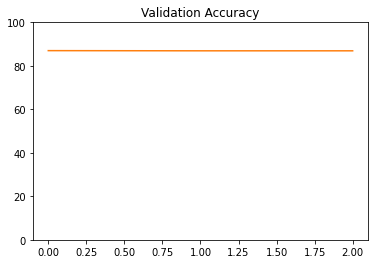

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(valAcc, color="tab:orange")
ax.set_ylim([0,100])
ax.set_title("Validation Accuracy")
plt.show()

original image


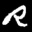

corner detection


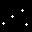

concatenated


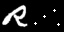

In [20]:
# experiment with effects of FAST  detection
print("original image")
input = np.float32(conv_train_data[61345][0])
#input = cv2.cvtColor(input, cv2.COLOR_GRAY2RGB)
cv2_imshow(input)
#print(input.shape)
corners = cv2.goodFeaturesToTrack(input,25,0.01,10)
corners = np.int0(corners)

out = np.zeros((32,32), dtype=float)
for i in corners:
  x,y = i.ravel()
  cv2.circle(out, (x,y), 1, 255, -1)

print("corner detection")
cv2_imshow(out)

combo = np.concatenate([input,out],1)
print("concatenated")
cv2_imshow(np.float32(combo))

In [21]:
# dataset class with corner detection added (may make things more difficult)
class handwrittenCharsGFTTDataset(Dataset):
    def __init__(self, X, classToNum):
      self.classToNum = classToNum
      self.images = []
      self.labels = []
      for i in X:
        self.images.append(i[0])
        self.labels.append(i[1])

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, index):
      # apply corner detection to image
      image = np.float32(self.images[index])
      corners = cv2.goodFeaturesToTrack(image,25,0.01,10)
      if (corners is not None):
        corners = np.int0(corners)
        out = np.zeros((32,32), dtype=float)
        for i in corners:
          x,y = i.ravel()
          cv2.circle(out, (x,y), 1, 255, -1)

      else:
        out = np.zeros((32,32), dtype=float)

      combo = np.concatenate([image,out],1)
      #cv2_imshow(combo)
      image = torch.tensor(combo)
      #print(image.shape)

      char = self.classToNum[self.labels[index]]
      end = self.classToNum["<EOS>"]
      label = tensor([char, end])

      #image = self.transform(image)
      #print(image.shape)
      #cv2_imshow(np.float32(image))
      sample = [image, label]
      return sample
    
    transform = T.Compose([
      #T.ToPILImage(),
      T.ToTensor()                     
    ])

In [22]:
batch_size = 10
dataset = handwrittenCharsGFTTDataset(X=conv_train_data, classToNum=invertedLabelDict)
GFTTTrain_dl = DataLoader(dataset, batch_size, shuffle=True, pin_memory=True)
GFTTLSTMModel = convLSTM(40, 10, 2).to(device)

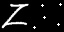

RuntimeError: ignored

In [23]:
testItem, testLabel = next(iter(GFTTTrain_dl))
#print(f"Feature batch shape: {testItem.size()}")
#print(f"Labels batch shape: {testLabel.size()}")

#testLabel = labelDict[testLabel[0].numpy().argmax()]
testLabel = testLabel.numpy()[0]

# some funny business to get image from tensor to see if guess is reasonable
#print(testItem[0].cpu().numpy()[0].shape)
image = testItem[0].cpu().numpy()
cv2_imshow(image)

hidden = GFTTLSTMModel.init_hidden()

# predict twice with same image but different hidden
output, hidden = GFTTLSTMModel(testItem.to(device), hidden)
output2, hidden = GFTTLSTMModel(testItem.to(device), hidden)

pred1 = labelDict[output[0][0].detach().cpu().numpy().argmax(0)]
pred2 = labelDict[output2[0][0].detach().cpu().numpy().argmax(0)]

print("predicted", pred1 + pred2, "for", "".join(toChars(testLabel, labelDict)))

In [ ]:
lossFunc = nn.CrossEntropyLoss()
opt = optim.SGD(CornerLSTMModel.parameters(), lr=0.001) 

num_epochs = 5
max_len = 2
batch_size = 10

GFTTLSTMtestLoss = []
GFTTLSTMtestAcc = []

for epoch in range(num_epochs):
  running_loss = 0
  running_acc = 0
  for i, data in enumerate(GFTTTrain_dl, 0):
    images, labels = data
    images, labels = images.to(device), labels.permute(1,0).to(device)

    opt.zero_grad()

    hidden = GFTTLSTMModel.init_hidden()

    outputs = []
    losses = []
    for j in range(max_len):
      GFTTLSTMModel.zero_grad()
      #hidden[0].detach_()
      #hidden[1].detach_()

      #print(images.shape)
      #print(hidden[0].shape)

      output, hidden = GFTTLSTMModel(images, hidden)
      hidden = (hidden[0].detach(), hidden[1].detach())

      #print(output[0].shape)
      #print(labels[j])

      loss = lossFunc(output[0], labels[j])
      #print(loss)
      loss.backward()
      opt.step()

      outputs.append(output[0])
      losses.append(loss)

    outputs = torch.stack(outputs)
    running_acc += findAccuracy(outputs, labels)

    #print(loss)
    running_loss += sum(losses).item()
    if i % 1000 == 999:
      GFTTLSTMtestLoss.append(running_loss)
      GFTTLSTMtestAcc.append(running_acc/10)
      print("[%d, %5d] loss: %.5f acc: %.3f%%" % (epoch + 1, i + 1, running_loss / 1000, running_acc / 10))
      running_loss = 0
      running_acc = 0

print("Done!")

[1,  1000] loss: 7.33560 acc: 1.300%
[1,  2000] loss: 7.33449 acc: 1.350%


KeyboardInterrupt: ignored

In [24]:
!unzip captcha.zip

Archive:  captcha.zip
   creating: captcha/
  inflating: captcha/captchaTrainSmall.npy  
  inflating: captcha/captchaValSmall.npy  


training data size: 308
validation data size: 14
training data shape: (50, 200)


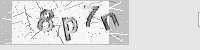

data type of image = <class 'numpy.ndarray'>
training data label: 8p7n
each index in dataset has image (50x200) and char label
[[192 192 192 ... 230 230 230]
 [192 192 192 ... 230 230 230]
 [192 192 192 ... 230 230 230]
 ...
 [230 230 230 ... 230 230 230]
 [230 230 230 ... 230 230 230]
 [230 230 230 ... 230 230 230]]


In [25]:
from google.colab.patches import cv2_imshow #allows us to show images

with open("captcha/captchaTrainSmall.npy", "rb") as f:
    capt_train_data = np.load(f, allow_pickle=True)

with open("captcha/captchaValSmall.npy", "rb") as f:
    capt_val_data = np.load(f, allow_pickle=True)

#capt_val_data = capt_val_data[:13000]

print("training data size:", len(capt_train_data))
print("validation data size:",len(capt_val_data))

item = capt_train_data[123]

print("training data shape:", item[0].shape)
cv2_imshow(item[0])
print("data type of image =", type(item[0]))
print("training data label:", item[1])
print("each index in dataset has image (50x200) and char label")
print(item[0])

In [12]:
labels = []
# used for stopping prediction of recurrent layers
labels.append("<EOS>") 
for i in capt_train_data:
  label = i[1]
  for char in label:
    if char not in labels:
      labels.append(char)

print("there are", len(labels), "labels in the training dataset")

for i in capt_val_data:
  label = i[1]
  for char in label:
    if char not in labels:
      labels.append(char)

print("there are", len(labels), "labels in the validation dataset")

captLabelDict = {}
for i in range(len(labels)):
  captLabelDict[i] = labels[i]

print(captLabelDict)
invertedCaptDict = {y:x for x,y in captLabelDict.items()}
print(invertedCaptDict)

there are 37 labels in the training dataset
there are 37 labels in the validation dataset
{0: '<EOS>', 1: '0', 2: '1', 3: 's', 4: 'e', 5: '3', 6: 'a', 7: '4', 8: 'r', 9: '5', 10: 'm', 11: 'b', 12: 'g', 13: 'v', 14: 'f', 15: 'i', 16: 'u', 17: 'j', 18: 'k', 19: '9', 20: 'l', 21: 't', 22: 'x', 23: '7', 24: 'w', 25: 'z', 26: '2', 27: 'y', 28: '8', 29: 'd', 30: 'h', 31: 'n', 32: 'q', 33: 'o', 34: 'p', 35: '6', 36: 'c'}
{'<EOS>': 0, '0': 1, '1': 2, 's': 3, 'e': 4, '3': 5, 'a': 6, '4': 7, 'r': 8, '5': 9, 'm': 10, 'b': 11, 'g': 12, 'v': 13, 'f': 14, 'i': 15, 'u': 16, 'j': 17, 'k': 18, '9': 19, 'l': 20, 't': 21, 'x': 22, '7': 23, 'w': 24, 'z': 25, '2': 26, 'y': 27, '8': 28, 'd': 29, 'h': 30, 'n': 31, 'q': 32, 'o': 33, 'p': 34, '6': 35, 'c': 36}


In [13]:
# dataset class
class captchaDataset(Dataset):
    def __init__(self, X, classToNum):
      self.classToNum = classToNum
      self.images = []
      self.labels = []
      for i in X:
        self.images.append(i[0])
        self.labels.append(i[1])

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, index):
      image = self.images[index]
      # turn all chars of label into numbers
      chars = []
      for i in range(len(self.labels[index])):
        char = self.classToNum[self.labels[index][i]]
        chars.append(char)
      # don't forget end of sentence 
      end = self.classToNum["<EOS>"]
      chars.append(end)
      # turn it all into a tensor
      label = tensor(chars)
      image = self.transform(image)
      sample = [image, label]
      return sample

    transform = T.Compose([
      T.ToPILImage(),
      T.ToTensor()                     
    ])

In [49]:
batch_size = 10
dataset = captchaDataset(X=capt_train_data, classToNum=invertedCaptDict)
capt_train_dl = DataLoader(dataset, batch_size, shuffle=True, pin_memory=True, drop_last=True)

In [50]:
# recurrent conv model to look at image and predict chars until all are read
# uses resnet structure

# Captcha version!

class captchaLSTM(nn.Module):
  def __init__(self, numClasses, batchSize, maxLen, lstmDepth):
    super(captchaLSTM, self).__init__()
    self.numClasses = numClasses
    self.batchSize = batchSize
    self.maxLen = maxLen
    self.lstmDepth = lstmDepth

    self.block1 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=2, stride=2, padding=3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True)
    )

    self.block2 = nn.Sequential(
        nn.MaxPool2d(1, 1),
        resBlock(64, 64),
        resBlock(64, 64, 2)
    )

    self.block3 = nn.Sequential(
        resBlock(64, 128),
        resBlock(128, 128, 2)
    )

    self.block4 = nn.Sequential(
        resBlock(128, 256),
        resBlock(256, 256, 2)
    )

    self.block5 = nn.Sequential(
        resBlock(256, 512),
        resBlock(512, 512, 2)
    )

    self.avgpool = nn.AvgPool2d(2)
    self.flatten = nn.Flatten()
    # 1536 is resulting size from captcha images
    self.l1 = nn.Linear(1536, 512)
    self.l2 = nn.Linear(512, 256)
    self.l3 = nn.Linear(256, numClasses)
    # input size, hidden size, num layers
    self.lstm1 = nn.LSTM(256, 256, self.lstmDepth)
    # turn values to 0 with probability 0.2
    self.drop1 = nn.Dropout(0.2)
    self.drop2 = nn.Dropout(0.2)

  def forward(self, x, h1):
    # resnet layers
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.avgpool(x)
    x = self.flatten(x)
    
    # reduce size of data and add dropout for better generalization
    x = self.l1(x)
    x = self.drop1(x)
    x = self.l2(x)
    x = self.drop2(x)

    #print(x.shape)
    
    # reshape image encoding so it has time dim on front
    x = x.reshape(1, self.batchSize, 256)

    x, h1 = self.lstm1(x, h1)

    # turn output to classes
    x = self.l3(x)
    return x, h1

  def init_hidden(self):
    return (torch.zeros(self.lstmDepth, self.batchSize, 256).to(device),
            torch.zeros(self.lstmDepth, self.batchSize, 256).to(device))

In [51]:
# create model instance
# 37 possible classes to predict
# 5 as max length pred because all images have 4 chars + eos
captchaModel = captchaLSTM(37, 10, 5, 1).to(device)

Feature batch shape: torch.Size([10, 1, 50, 200])
Labels batch shape: torch.Size([10, 5])


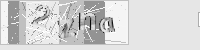

predicted gzzzz for 2zna<EOS>


In [52]:
testItem, testLabel = next(iter(capt_train_dl))
print(f"Feature batch shape: {testItem.size()}")
print(f"Labels batch shape: {testLabel.size()}")

#testLabel = labelDict[testLabel[0].numpy().argmax()]
testLabel = testLabel.numpy()[0]

# some funny business to get image from tensor to see if guess is reasonable
image = testItem[0].cpu().numpy()[0] * 255
cv2_imshow(image)

h1 = captchaModel.init_hidden()

# predict twice with same image but different hidden
output, h1 = captchaModel(testItem.to(device), h1)
output2, h1 = captchaModel(testItem.to(device), h1)
output3, h1 = captchaModel(testItem.to(device), h1)
output4, h1 = captchaModel(testItem.to(device), h1)
output5, h1 = captchaModel(testItem.to(device), h1)

pred1 = captLabelDict[output[0][0].detach().cpu().numpy().argmax(0)]
pred2 = captLabelDict[output2[0][0].detach().cpu().numpy().argmax(0)]
pred3 = captLabelDict[output3[0][0].detach().cpu().numpy().argmax(0)]
pred4 = captLabelDict[output4[0][0].detach().cpu().numpy().argmax(0)]
pred5 = captLabelDict[output5[0][0].detach().cpu().numpy().argmax(0)]

print("predicted", pred1 + pred2 + pred3 + pred4 + pred5, "for", "".join(toChars(testLabel, captLabelDict)))

In [53]:
lossFunc = nn.CrossEntropyLoss()
opt = optim.SGD(captchaModel.parameters(), lr=0.001) 

num_epochs = 2000
max_len = 2
batch_size = 10

#captchaTestLoss = []
#captchaTestAcc = []

for epoch in range(num_epochs):
  running_loss = 0
  running_acc = 0
  for i, data in enumerate(capt_train_dl, 0):
    images, labels = data
    images, labels = images.to(device), labels.permute(1,0).to(device)

    opt.zero_grad()

    h1 = captchaModel.init_hidden()

    outputs = []
    losses = []
    for j in range(max_len):
      captchaModel.zero_grad()

      #print(images.shape)
      #print(hidden[0].shape)

      output, h1 = captchaModel(images, h1)
      h1 = (h1[0].detach(), h1[1].detach())

      #print(output[0].shape)
      #print(labels[j])

      loss = lossFunc(output[0], labels[j])
      #print(loss)
      loss.backward()
      opt.step()

      outputs.append(output[0])
      losses.append(loss)

    outputs = torch.stack(outputs)
    running_acc += findAccuracy(outputs, labels)

    #print(loss)
    running_loss += sum(losses).item()
    # if last batch of epoch
    if i == 29 :
      captchaTestLoss.append(running_loss)
      captchaTestAcc.append(running_acc/10)
      print("[%d, %3d] loss: %.5f acc: %.3f%%" % (epoch + 1, i + 1, running_loss / 100, running_acc))
      running_loss = 0
      running_acc = 0

print("Done!")

[1,  30] loss: 2.16470 acc: 0.650%
[2,  30] loss: 2.16196 acc: 0.900%
[3,  30] loss: 2.15817 acc: 1.300%
[4,  30] loss: 2.15547 acc: 1.700%
[5,  30] loss: 2.15384 acc: 2.100%
[6,  30] loss: 2.15106 acc: 2.600%
[7,  30] loss: 2.14789 acc: 2.550%
[8,  30] loss: 2.14575 acc: 2.900%
[9,  30] loss: 2.14292 acc: 3.250%
[10,  30] loss: 2.13976 acc: 3.100%
[11,  30] loss: 2.13954 acc: 3.400%
[12,  30] loss: 2.13626 acc: 3.150%
[13,  30] loss: 2.13269 acc: 2.950%
[14,  30] loss: 2.13059 acc: 3.300%
[15,  30] loss: 2.12904 acc: 2.900%
[16,  30] loss: 2.12628 acc: 3.150%
[17,  30] loss: 2.12372 acc: 3.050%
[18,  30] loss: 2.12191 acc: 3.400%
[19,  30] loss: 2.12002 acc: 2.800%
[20,  30] loss: 2.11755 acc: 2.550%
[21,  30] loss: 2.11526 acc: 2.600%
[22,  30] loss: 2.11319 acc: 2.750%
[23,  30] loss: 2.10933 acc: 2.800%
[24,  30] loss: 2.10818 acc: 2.500%
[25,  30] loss: 2.10645 acc: 2.750%
[26,  30] loss: 2.10471 acc: 2.950%
[27,  30] loss: 2.10058 acc: 2.800%
[28,  30] loss: 2.10042 acc: 2.400%
[

In [23]:
# dataset class
class captchaCornerDataset(Dataset):
    def __init__(self, X, classToNum):
      self.classToNum = classToNum
      self.images = []
      self.labels = []
      for i in X:
        self.images.append(i[0])
        self.labels.append(i[1])

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, index):
      # corner detection
      image = np.float32(self.images[index])
      image = image * cv2.cornerHarris(image, 2, 3, 0.04)
      # turn all chars of label into numbers
      chars = []
      for i in range(len(self.labels[index])):
        char = self.classToNum[self.labels[index][i]]
        chars.append(char)
      # don't forget end of sentence 
      end = self.classToNum["<EOS>"]
      chars.append(end)
      # turn it all into a tensor
      label = tensor(chars)
      image = self.transform(image)
      sample = [image, label]
      return sample

    transform = T.Compose([
      T.ToPILImage(),
      T.ToTensor()                     
    ])

In [34]:
batch_size = 10
dataset = captchaCornerDataset(X=capt_train_data, classToNum=invertedCaptDict)
capt_corner_train_dl = DataLoader(dataset, batch_size, shuffle=True, pin_memory=True, drop_last=True)
captchaCornerModel = captchaLSTM(37, 10, 5, 1).to(device)

Feature batch shape: torch.Size([10, 1, 50, 200])
Labels batch shape: torch.Size([10, 5])


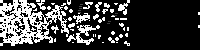

predicted vsnhb for 5e1d<EOS>


In [40]:
testItem, testLabel = next(iter(capt_corner_train_dl))
print(f"Feature batch shape: {testItem.size()}")
print(f"Labels batch shape: {testLabel.size()}")

#testLabel = labelDict[testLabel[0].numpy().argmax()]
testLabel = testLabel.numpy()[0]

# some funny business to get image from tensor to see if guess is reasonable
image = testItem[0].cpu().numpy()[0] * 255
cv2_imshow(image)

h1 = captchaCornerModel.init_hidden()

# predict twice with same image but different hidden
output, h1 = captchaCornerModel(testItem.to(device), h1)
output2, h1 = captchaCornerModel(testItem.to(device), h1)
output3, h1 = captchaCornerModel(testItem.to(device), h1)
output4, h1 = captchaCornerModel(testItem.to(device), h1)
output5, h1 = captchaCornerModel(testItem.to(device), h1)

pred1 = captLabelDict[output[0][0].detach().cpu().numpy().argmax(0)]
pred2 = captLabelDict[output2[0][0].detach().cpu().numpy().argmax(0)]
pred3 = captLabelDict[output3[0][0].detach().cpu().numpy().argmax(0)]
pred4 = captLabelDict[output4[0][0].detach().cpu().numpy().argmax(0)]
pred5 = captLabelDict[output5[0][0].detach().cpu().numpy().argmax(0)]

print("predicted", pred1 + pred2 + pred3 + pred4 + pred5, "for", "".join(toChars(testLabel, captLabelDict)))

In [44]:
lossFunc = nn.CrossEntropyLoss()
opt = optim.SGD(captchaCornerModel.parameters(), lr=0.001) 

num_epochs = 1000
max_len = 2
batch_size = 10

#captchaCornerTestLoss = []
#captchaCornerTestAcc = []

for epoch in range(num_epochs):
  running_loss = 0
  running_acc = 0
  for i, data in enumerate(capt_corner_train_dl, 0):
    images, labels = data
    images, labels = images.to(device), labels.permute(1,0).to(device)

    opt.zero_grad()

    h1 = captchaCornerModel.init_hidden()

    outputs = []
    losses = []
    for j in range(max_len):
      captchaCornerModel.zero_grad()

      #print(images.shape)
      #print(hidden[0].shape)

      output, h1 = captchaCornerModel(images, h1)
      h1 = (h1[0].detach(), h1[1].detach())

      #print(output[0].shape)
      #print(labels[j])

      loss = lossFunc(output[0], labels[j])
      #print(loss)
      loss.backward()
      opt.step()

      outputs.append(output[0])
      losses.append(loss)

    outputs = torch.stack(outputs)
    running_acc += findAccuracy(outputs, labels)

    #print(loss)
    running_loss += sum(losses).item()
    # if last batch of epoch
    if i == 29 :
      captchaCornerTestLoss.append(running_loss)
      captchaCornerTestAcc.append(running_acc/10)
      print("[%d, %3d] loss: %.5f acc: %.3f%%" % (epoch + 1, i + 1, running_loss / 100, running_acc))
      running_loss = 0
      running_acc = 0

print("Done!")

[1,  30] loss: 0.23062 acc: 26.950%
[2,  30] loss: 0.22118 acc: 27.450%
[3,  30] loss: 0.22321 acc: 27.600%
[4,  30] loss: 0.22269 acc: 27.300%
[5,  30] loss: 0.22800 acc: 27.000%
[6,  30] loss: 0.22230 acc: 27.400%
[7,  30] loss: 0.22030 acc: 27.300%
[8,  30] loss: 0.21852 acc: 27.650%
[9,  30] loss: 0.22937 acc: 27.250%
[10,  30] loss: 0.22877 acc: 27.100%
[11,  30] loss: 0.22649 acc: 27.300%
[12,  30] loss: 0.21782 acc: 27.650%
[13,  30] loss: 0.22353 acc: 27.650%
[14,  30] loss: 0.22578 acc: 26.950%
[15,  30] loss: 0.22217 acc: 27.300%
[16,  30] loss: 0.21766 acc: 27.600%
[17,  30] loss: 0.21574 acc: 27.750%
[18,  30] loss: 0.21742 acc: 27.250%
[19,  30] loss: 0.21481 acc: 27.400%
[20,  30] loss: 0.22159 acc: 27.600%
[21,  30] loss: 0.21390 acc: 27.600%
[22,  30] loss: 0.22260 acc: 27.200%
[23,  30] loss: 0.21651 acc: 27.200%
[24,  30] loss: 0.21620 acc: 27.950%
[25,  30] loss: 0.21346 acc: 27.600%
[26,  30] loss: 0.21504 acc: 27.750%
[27,  30] loss: 0.21324 acc: 27.400%
[28,  30] 

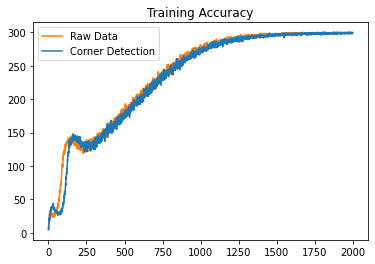

In [55]:
captchaTestAcc = [i*10 for i in captchaTestAcc]
captchaTestAcc = captchaTestAcc[1000:]
captchaCornerTestAcc = [i*10 for i in captchaCornerTestAcc]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(captchaTestAcc, color="tab:orange", label="Raw Data")
ax.plot(captchaCornerTestAcc, color="tab:blue", label="Corner Detection")
#ax.set_ylim([0,100])
ax.set_title("Training Accuracy")
plt.legend()
plt.show()